# Portfolio allocation

In this note we describe basic mean-variance approaches to asset allocation: Markowitz problem and Sharpe ratio. We demonstrate there properties using an imaginary universe of 3 assets, and the stocks included into Dow Jones index.

<a name="toc"></a>

## Table of contents

<ul>
<li><a href="#portalloc">Portfolio allocation problem</a></li>
  <ul>
  <li><a href="#sharpe">Sharpe ratio</a></li>
  <li><a href="#markowitz">Markowitz problem</a></li>
  </ul>
<li><a href="#basic_code">Basic Python code</a></li>
<li><a href="#illustration">Inllustration in risk-return plane</a></li>
  <ul>
  <li><a href="#long_short">Unconstrained (long/short) and constrained (long only) allocation</a></li>
  <li><a href="#monte_carlo">Admissible region for constrained problems (Monte Carlo)</a></li>
  </ul>
<li><a href="#dow_jones">Portfolios of Dow Jones stocks</a></li>
  <ul>
  <li><a href="#high_ret">Allocation among top 5 stocks with highest returns</a></li>
  <li><a href="#low_risk">Allocation among top 5 stocks with lowest risk</a></li>
  <li><a href="#dj_all">Allocation among total Dow Jones universe</a></li>
  <li><a href="#summary_dj">Summary of Dow Jones allocation</a></li>
  </ul>
</ul>

<a name="portalloc"></a>

## Portfolio allocation problem

Given a portfolio of $n$ assets with random vactor of returns $X$ possessing and mean vector $m$ and covariance matrix $C$, we may select weights $w$ and construct a portfolio $P=w'X$ with mean $EP=w'm$ and variance $V=w'Cw$. Portfolio allocation problem, sometimes referred to as asset allocation problem, consists in selecting weights $w$ in such a way that some optimality conditions are met, with possible constraints imposed on portfolio returns $P$ or its moments $m$ and $V$, and on weights $w$. In what follows we will use the notation $I=(1,\dots,1)'\in R^n$.

<a name="sharpe"></a>

### Sharpe ratio

Given risk free rate $r$ and an asset (or portfolio) with mean $\mu>r$ and variance $\sigma^2$, the Sharpe ratio of the asset equals to

$$
S=\frac{\mu-r}{\sigma}.
$$

Thus we have the following optimization problem

$$
\frac{w'm-r}{\sqrt{w'Cw}}\to\max_w,
$$

$$
w'I=1.
$$

<a name="markowitz"></a>

### Markowitz problem

Markowitz problem is somewhat similar to optimizing Sharpe ratio, yet a bit different. Given asset returns $X$, and desired level of risk $\sigma^2$, the problem is to find weights $w$ such that portfolio risk $V$ does not exceed $\sigma^2$, and portfolio return is as large as possible, that is

$$
w'm\to\max_w,
$$
$$
w'Cw\leq\sigma^2,
$$
$$
\sum_{i=1}^m w_i=1.
$$

Equivalent formlation requires finding minimum portfolio risk $V$, given desired level of expected return $M$, that is,

$$
w'Cw\to\min_w,
$$
$$
w'm=M,
$$
$$
\sum_{i=1}^m w_i=1.
$$

If short positions are prohibited, we would add a non-negativity restriction

$$
w_i\geq0,\;i=1,\dots,n.
$$

To express the Markowitz problem solution we need some convenient notation. Denote $(x,y)$ the 'energy' scalar product with matrix $C^{-1}$, and $\|x\|=\sqrt{(x,x)}$ the corresponding 'energy' norm in $R^n$, that is

$$
(x,y)=x'C^{-1}y,\;\;\|x\|^2=(x,x)=x'C^{-1}x.
$$

Next, denote $\Delta=\|m\|^2\|I\|^2-(m,I)^2$. Then the solution of generic Markowitz problem (without non-negativity restriction) takes the form

$$
w_M=\frac{M\|I\|^2-(m,I)}{\Delta}C^{-1}m+\frac{\|m\|^2-M(m,I)}{\Delta}C^{-1}I=A_MC^{-1}m+B_MC^{-1}I.
$$

The corresponding values of portfolio risk and return are $V_M=w_M'Cw_M=\|A_Mm+B_MI\|^2$ and $r_M=M$, as expected.

The minimum possible risk is attained without the $w'm=M$ restriction under

$$
w_*=\frac{C^{-1}I}{\|I\|^2},
$$

it equals to

$$
V_*=\frac1{\|I\|^2},
$$

and provides the return

$$
r_*=\frac{(m,I)}{\|I\|^2}.
$$

Parabola $\sigma^2=f(M)$ in the plane $(\sigma^2, M)$ with

$$
f(M)=\|A_Mm+B_MI\|^2=\frac1{\Delta}\left(M^2\|I\|^2-2M(m,I)+\|m\|^2\right)
$$

is known as Markowitz bullet, its upper portion corresponding to values $M\geq r_*$ is called efficient frontier.

Illustrations of the concepts follow.

<a href="#toc">Back to table of contents</a>

<a name="basic_code"></a>

## Basic Python code

### Importing Python tools

In [1]:
# import some standard modules
import pandas as pd
from scipy.optimize import minimize
import fin_stuff as fs
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Miscelaneous functions

In [2]:
# global variable, what is risk: variance or standard deviation?
risk_as_vol=True

def riskval(variance):
    """ return variance or standard deviation for a risk figure """
    return np.sqrt(variance) if risk_as_vol else variance

def portfolio(c, m, w):
    """ risk and return """
    ret = w.dot(m)
    risk = w.dot(c.dot(w))
    return {'risk': risk, 'return': ret}

def soft_join(sep, los, max_items):
    """ joins items of los (not more than max_items) to a string """
    return sep.join(los) if len(los) <= max_items else \
        sep.join(los[:max_items]) + sep + '...'

### Sharpe functions

In [3]:
def maximize_sharpe_ratio(c, m, r, long_only = False):
    """ numeric solution for constrained portfolio """
    def minus_sharpe(w):
        """ goal function """
        return -(w.dot(m) - r) / np.sqrt(w.dot(c.dot(w)))
    def sum1_constr(w):
        """ constraint """
        return w.sum() - 1
    
    # optimization
    w0 = np.ones((len(m),))
    cons = ({'type': 'eq', 'fun': sum1_constr})
    bnds = [(0, 1000000)] * len(m) if long_only else None
    mm = minimize(minus_sharpe, w0, bounds=bnds, constraints=cons)
    
    # prepare solution for output
    w = mm.x
    po = portfolio(c, m, w)
    mu = po['return']
    sig = np.sqrt(po['risk'])
    return {'w': w, 'mu': mu, 'sig': sig, 'sr': (mu - r) / sig}


### Markowitz functions

In [4]:
def markowitz_parameters(c, m, include_vectors=False):
    """ all the parameters linked to risk-return setting """
    I = np.ones((len(m),))                     # I
    ci = np.linalg.solve(c,I)                  # C^(-1)I
    cm = np.linalg.solve(c,m)                  # C^(-1)m
    Im = I.dot(cm)                             # (I,m)
    I2 = I.dot(ci)                             # |I|^2
    m2 = m.dot(cm)                             # |m|^2
    V_st = 1 / I2                              # V-star
    st_st = np.sqrt(V_st)                      # minimum standard deviation
    r_st = Im / I2                             # r-star
    Delta = m2 * I2 - Im ** 2                  # Delta
    # w_st = ci / I2                           # w-star
    dd = {'Im': Im, 'I2': I2, 'm2': m2, 'Delta': Delta,
            'st_st': st_st, 'V_st': V_st, 'r_st': r_st}
    if include_vectors:
        dd['ci'] = ci
        dd['cm'] = cm
    return dd

def show_markowitz_parameters(c, m):
    """ """
    ss = markowitz_parameters(c, m)
    sss = {k: '{0:10.2f}'.format(ss[k]).strip() for k in ss}
    sf = ', '.join([s + ' = ' + '{' + s + '}' for s in sss])
    print(sf.format(**sss))

def markowitz_bullet(M, mark_pars):
    """ """
    risk = (mark_pars['I2'] * M ** 2 - 2 * mark_pars['Im'] * M + \
            mark_pars['m2']) / mark_pars['Delta']
    return risk

def markowitz_bullet_constr(c, m, M):
    """ Constrained Markowitz bullet """
    risk = [minimize_mark_risk(c, m, M[i], long_only = True)['risk'] \
            for i in range(len(M))]
    return risk

def markowitz_solution(c, m, M, calc_weights = False):
    """ short/long analytic solution """
    mark_pars = markowitz_parameters(c, m, include_vectors=calc_weights)
    risk = markowitz_bullet(M, mark_pars)
    if calc_weights:
        AM = (M * mark_pars['I2'] - mark_pars['Im']) / mark_pars['Delta']
        BM = (mark_pars['m2'] - M * mark_pars['Im']) / mark_pars['Delta']
        w = AM * mark_pars['cm'] + BM * mark_pars['ci']
        return {'risk': risk, 'w': w, 'mu': M, 'sig': np.sqrt(risk)}
    else:
        return risk

def minimize_mark_risk(c, m, M, long_only = False):
    """ numeric solution for constrained (long_only = True)
    or unconstrained long_only = False) portfolio
    """
    def mark_goal(w):
        """ """
        return np.sqrt(w.dot(c.dot(w)))
    def sum_constr(w):
        """ vector of constraints """
        return [w.sum() - 1, w.dot(m) - M]
    w0 = np.ones((len(m),))
    cons = ({'type': 'eq', 'fun': sum_constr})
    # bnds = [(0, 1000000)] * len(m) if long_only else None
    bnds = [[0, 1000000]] * len(m) if long_only else None
    mm = minimize(mark_goal, w0, bounds=bnds, constraints=cons)
    w = mm.x
    po = portfolio(c, m, w)
    mu = po['return']
    sig = np.sqrt(po['risk'])
    return {'w': w, 'mu': mu, 'sig': sig, 'risk': sig ** 2, 'mm': mm,
            'residual': np.abs(sum_constr(w)).sum()}

<a href="#toc">Back to table of contents</a>

<a name="illustration"></a>

## Illustration in risk-return plane

We use plane illustrations with portfolio variance along the horizontal axis, and portfolio expected return along the vertical axis.

### Define example covariance matrix and vector of expected returns

In [5]:
# set up covariance matrix and expected return for 3-assets vector,
m = np.array([10,20,40])
c = np.array([[30,15,0],[15,20,-10],[0,-10,20]])
M = 35
r = 5

### Markowitz parameters

In [6]:
show_markowitz_parameters(c, m)

Im = 7.00, I2 = 0.22, m2 = 246.67, Delta = 4.44, st_st = 2.15, V_st = 4.62, r_st = 32.31


Thus we see that the top of Markowitz bullet has coordinates return = 32.31, and risk = 4.62 (standard deviation = 2.15). Efficient frontier corresponds to returns greater than 32.31.

<a name="long_short"></a>

### Unconstrained (long/short) and constrained (long only) allocation

In [7]:
# define utility for building charts
def mark_sharpe_charts(c, m, M, r):
    """ """
    mark_pars = markowitz_parameters(c, m)
    r_st = mark_pars['r_st']
    Ms = '{0:10.3f}'.format(M).strip()
    
    figsize(14,5)
    
    # ======================================================
    # short positions allowed
    # ======================================================
    
    subplot(1,2,1)
    
    # two branches of the Markowitz bullet
    Md = np.linspace(m.min(), r_st, 101)
    Mu = np.linspace(r_st, m.max(), 101)
    sigd = riskval(markowitz_bullet(Md, mark_pars))
    sigu = riskval(markowitz_bullet(Mu, mark_pars))
    plot(sigu, Mu, 'r', label='efficient frontier')
    plot(sigd, Md, 'g', label='lower bullet fragment')
    title('Short positions allowed')
    xlabel('Volatility' if risk_as_vol else 'Risk')
    ylabel('Return')
    
    # Markowitz problem
    ms = markowitz_solution(c, m, M, calc_weights=True)
    risk = ms['risk']
    ws = ['{0:10.3f}'.format(x).strip() for x in ms['w']]
    risks = '{0:10.3f}'.format(risk).strip()
    weights = ', '.join(ws)
    mark_lab = 'Markowitz solution (M = {0})'.format(M)
    scatter(riskval(risk), M, label=mark_lab)
    
    # Sharpe ratio
    msr = maximize_sharpe_ratio(c, m, r)
    wsh = ['{0:10.3f}'.format(x).strip() for x in msr['w']]
    riskr = '{0:10.3f}'.format(msr['sig'] ** 2).strip()
    retr = '{0:10.3f}'.format(msr['mu']).strip()
    weightsh = ', '.join(wsh)
    scatter(riskval(msr['sig'] ** 2), msr['mu'], label='Sharpe solution')
    ll = legend()
    
    print('============================= Unconstrained problem ======================')
    print('Markowitz solution for M = {0}:  risk {1}, weights {2}'. \
          format(Ms, risks, weights))
    print('Sharpe solution:    return {0},  risk {1}, weights {2}'. \
          format(retr, riskr, weightsh))
    
    # ======================================================
    # short positions prohibited
    # ======================================================
    
    subplot(1,2,2)
    
    # plot original Markowitz bullet as a landmark
    Md = np.linspace(m.min(), r_st, 101)
    Mu = np.linspace(r_st, m.max(), 101)
    sigd = riskval(markowitz_bullet(Md, mark_pars))
    sigu = riskval(markowitz_bullet(Mu, mark_pars))
    plot(sigu, Mu, color='0.75')
    plot(sigd, Md, color='0.75', label='original bullet')
    title('Short positions prohibited')
    xlabel('Volatility' if risk_as_vol else 'Risk')
    ylabel('Return')
    
    # constrained Markowitz bullet
    Mdc = np.linspace(m.min(), r_st, 51)
    riskd = riskval(markowitz_bullet_constr(c, m, Mdc))
    Muc = np.linspace(r_st, m.max(), 51)
    risku = riskval(markowitz_bullet_constr(c, m, Muc))
    plot(risku, Muc, color='r', label='efficient frontier')
    plot(riskd, Mdc, color='g', label='lower bullet fragment')
    
    # Constrained Markowitz problem
    ms = minimize_mark_risk(c, m, M, long_only = True)
    mark_lab = 'Markowitz solution (M = {0})'.format(M)
    risk = ms['risk']
    scatter(riskval(risk), M, label=mark_lab)
    risks = '{0:10.3f}'.format(risk).strip()
    weights = ', '.join(['{0:10.3f}'.format(x).strip() for x in ms['w']])
    
    # Sharpe ratio
    msr = maximize_sharpe_ratio(c, m, r, long_only=True)
    wsh = ['{0:10.3f}'.format(x).strip() for x in msr['w']]
    riskr = '{0:10.3f}'.format(msr['sig'] ** 2).strip()
    retr = '{0:10.3f}'.format(msr['mu']).strip()
    weightsh = ', '.join(wsh)
    scatter(riskval(msr['sig'] ** 2), msr['mu'], label='Sharpe solution')
    ll = legend()
    
    print('============================= Constrained problem ========================')
    print('Markowitz solution for M = {0}:  risk {1}, weights {2}'. \
          format(Ms, risks, weights))
    print('Sharpe solution:    return {0},  risk {1}, weights {2}'. \
          format(retr, riskr, weightsh))

#### Call charting utility

============================= Unconstrained problem ======================
Markowitz solution for M = 35.000:  risk 4.969, weights -0.275, 0.663, 0.613
Sharpe solution:    return 35.775,  risk 5.201, weights -0.310, 0.676, 0.634
============================= Constrained problem ========================
Markowitz solution for M = 35.000:  risk 8.750, weights 0.000, 0.250, 0.750
Sharpe solution:    return 31.333,  risk 5.266, weights 0.000, 0.433, 0.567


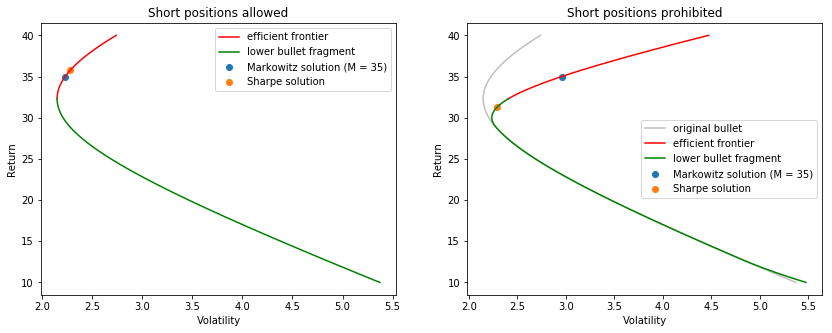

In [8]:
M = 35
r = 5
mark_sharpe_charts(c, m, M, r)

<a href="#toc">Back to table of contents</a>

<a name="monte_carlo"></a>

### Admissible region for constrained problems (Monte Carlo)

In this case analytical derivation of admissible region is cumbersome, so we use Monte Carlo simulations to illustrate the concept.

In [9]:
def show_adm_region(c, m, M, r):
    """ show admissible region and some solutions for constrained problems """
    # solve Sharpe and Markowitz for the data
    mc = minimize_mark_risk(c, m, M, long_only=True)        # constrained Markowitz problem
    mu = minimize_mark_risk(c, m, M, long_only=False)       # unconstrained Markowitz problem
    msc = maximize_sharpe_ratio(c, m, r, long_only=True)    # constrained Sharpe ratio
    msu = maximize_sharpe_ratio(c, m, r, long_only=False)   # unconstrained Sharpe ratio
    
    # original Markowitz bullet as a landmark
    mark_pars = markowitz_parameters(c, m)
    r_st = mark_pars['r_st']
    Md = np.linspace(m.min(), r_st, 101)
    Mu = np.linspace(r_st, m.max(), 101)
    sigd = riskval(markowitz_bullet(Md, mark_pars))
    sigu = riskval(markowitz_bullet(Mu, mark_pars))

    # create an illustrative chart
    n_trials = 10000
    figsize(8,5)
    
    w = fs.random_simplex_points(n_trials, 3)               # random portfolios, non-negative weights
    ret = w.dot(m)                                          # returns of those portfolios
    risk = riskval(np.diag(w.dot(c).dot(w.T)))              # risk of those portfolios
    ti = title('Admissible region for constrained problems, solution of selected problems')
    sc = scatter(risk, ret, s=1, label='admissible points')
    scc = scatter(riskval(msc['sig'] ** 2), msc['mu'], c='r',
                  label='constrained Sharpe ratio')
    scu = scatter(riskval(msu['sig'] ** 2), msu['mu'], c='g',
                  label='unconstrained Sharpe ratio')
    smc = scatter(riskval(mc['sig'] ** 2), mc['mu'], c='k',
                  label='constrained Markowitz, M = {0}'.format(M))
    smu = scatter(riskval(mu['sig'] ** 2), mu['mu'], c='y',
                  label='unconstrained Markowitz, M = {0}'.format(M))
    plu = plot(sigu, Mu, 'r', label='efficient frontier (unconstrained)')
    pld = plot(sigd, Md, 'g', label='lower bullet fragment (unconstrained)')
    xlabel('Volatility' if risk_as_vol else 'Risk')
    ylabel('Return')
   
    ll = legend(loc=1)

In the following chart we depict the Markowitz bullet for unconstrained problem (red and green), and interior of the Markowitz bullet (set of admissible points) for constrained problem by blue dots. Bold dots represent Markowitz and Sharpe solutions in both constrained and uncnstrained cases.

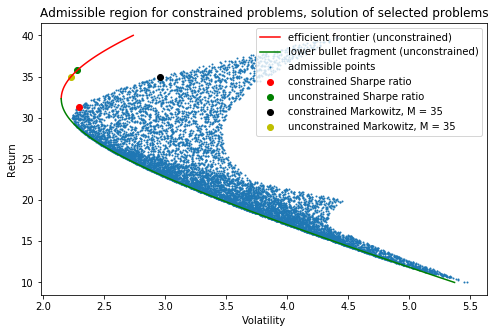

In [10]:
M = 35
r = 5
show_adm_region(c, m, M, r)

<a href="#toc">Back to table of contents</a>

<a name="dow_jones"></a>

## Portfolios of Dow Jones stocks

In this section we construct portfolios for stocks currently included in Dow Jones index.

###  Read the data and make preliminary calculations

In [11]:
# quotes Dow Jones index data
df = fs.read_dj_data(start_date='2009-01-01')

# asset names (asset tickers)
cl = df.columns

# compute daily returns from data
rets = fs.calc_returns(df)

# horizon in business days (1 year)
hor = 250

# annual risk free rate 2%
rf = 0.02

# mean vector and covariance matrix of the whole assets universe
# for the 1 year horizon, percentage
mt = rets.mean() * hor * 100
ct = rets.cov() * hor * 10000

# summary dataframe for Dow Jones portfolios
summary_dj = pd.DataFrame(columns=['Return', 'Volatility', 'Weights, %', 'Stocks'])

### Close quotes in 2009 - 2016 review

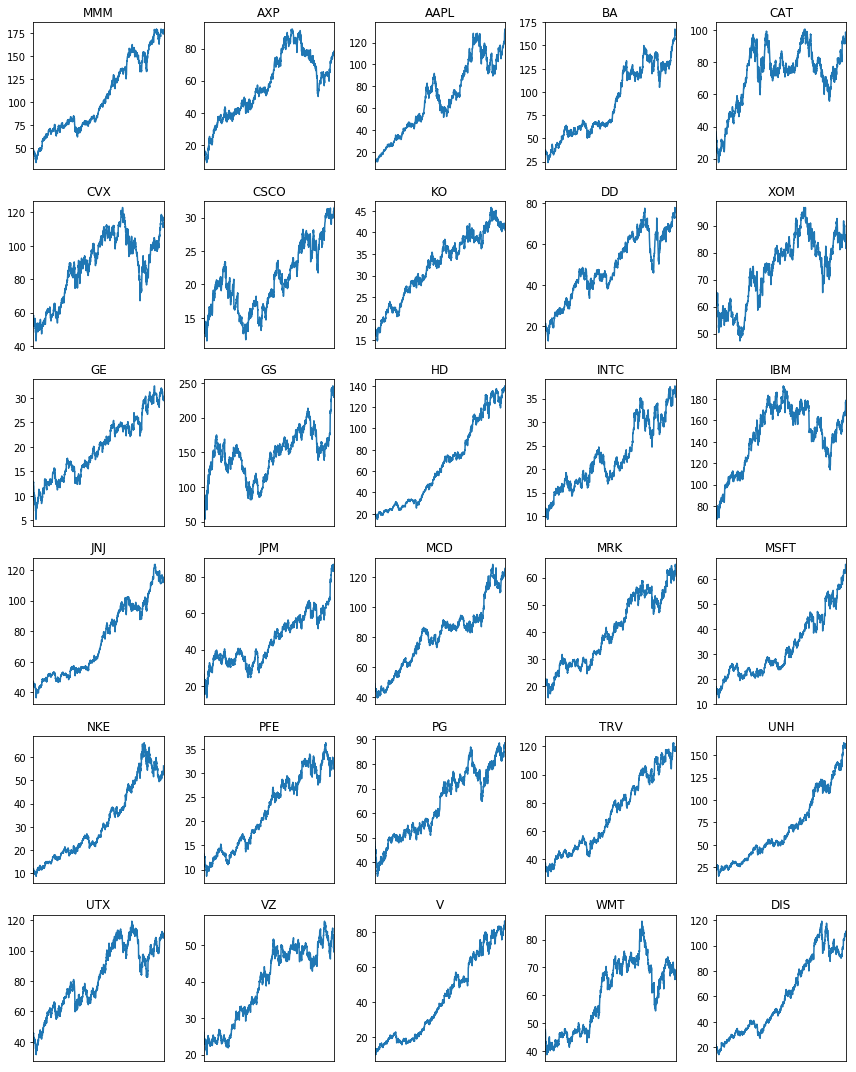

In [12]:
def make_all_plots(df):
    figsize(12,15)
    for i in range(df.shape[1]):
        subplot(6,5,i + 1)
        df[cl[i]].plot()
        title(cl[i])
        xticks([])
        xlabel('')
    tight_layout()
    
make_all_plots(df)

<a href="#toc">Back to table of contents</a>

### Annual expected returns and volatilities

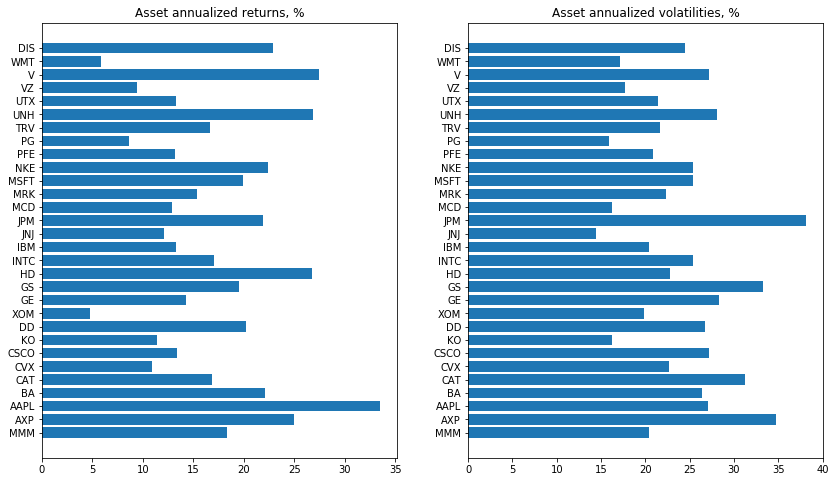

In [13]:
def chart_exp_ret_vols(ct, mt):
    """ """
    figsize(14,8)
    
    subplot(1,2,1)
    x = range(len(mt))
    bb = barh(x,mt)
    yy = yticks(x, mt.index)
    ti = title('Asset annualized returns, %')
    
    subplot(1,2,2)
    z = np.sqrt(np.diag(ct))
    x = range(len(z))
    bb = barh(x,z)
    yy = yticks(x, mt.index)
    ti = title('Asset annualized volatilities, %')

chart_exp_ret_vols(ct, mt)

<a href="#toc">Back to table of contents</a>

## Risk-return plane for Dow Jones stocks

In [14]:
def dj_port(ct, mt, M, r, assets):
    """ """
    
    # select returns and covariance for the assets fiven
    m = mt[assets]
    c = ct.loc[assets, assets]
    I = np.ones((len(m),))
    
    # calculate bullet parameters
    mark_pars = markowitz_parameters(c, m)
    r_st = mark_pars['r_st']

    # solve Sharpe and Markowitz for the data
    mc = minimize_mark_risk(c, m, M, long_only=True)        # constrained Markowitz problem
    mu = minimize_mark_risk(c, m, M, long_only=False)       # unconstrained Markowitz problem
    msc = maximize_sharpe_ratio(c, m, r, long_only=True)    # constrained Sharpe ratio
    msu = maximize_sharpe_ratio(c, m, r, long_only=False)   # unconstrained Sharpe ratio
    
    figsize(6,4)
    
    # plot original Markowitz bullet as a landmark
    Md = np.linspace(m.min(), r_st, 101)
    Mu = np.linspace(r_st, m.max(), 101)
    sigd = riskval(markowitz_bullet(Md, mark_pars))
    sigu = riskval(markowitz_bullet(Mu, mark_pars))
    plot(sigu, Mu, color='0.75')
    plot(sigd, Md, color='0.75', label='unconstrained bullet')
    title(', '.join(assets))
    xlabel('Volatility' if risk_as_vol else 'Risk')
    ylabel('Return')
    
    # constrained Markowitz bullet
    Mdc = np.linspace(m.min(), r_st, 51)
    riskd = riskval(markowitz_bullet_constr(c, m, Mdc))
    Muc = np.linspace(r_st, m.max(), 51)
    risku = riskval(markowitz_bullet_constr(c, m, Muc))
    plot(risku, Muc, color='r', label='efficient frontier')
    plot(riskd, Mdc, color='g', label='lower bullet fragment')
    
    # Constrained Markowitz problem
    ms = minimize_mark_risk(c, m, M, long_only = True)
    mark_lab = 'Markowitz solution (M = {0})'.format(M)
    scatter(riskval(ms['risk']), M, label=mark_lab)
    risk = ms['risk']
    risks = '{0:10.3f}'.format(ms['risk']).strip()
    vols = '{0:10.3f}'.format(np.sqrt(ms['risk'])).strip()
    ind = (np.abs(ms['w']) > 0.0001)
    aw = ms['w'][ind]
    weights = ', '.join(['{0:10.1f}'.format(100 * x).strip() for x in aw])
    act_mr = ','.join(m.index[ind])
    
    # Sharpe ratio
    msr = maximize_sharpe_ratio(c, m, r, long_only=True)
    act_sh = ','.join(mt.index[msr['w'].nonzero()[0]])
    riskr = '{0:10.3f}'.format(msr['sig'] ** 2).strip()
    volr = '{0:10.3f}'.format(msr['sig']).strip()
    retr = '{0:10.3f}'.format(msr['mu']).strip()
    ind = (np.abs(msr['w']) > 0.0001)
    awr = msr['w'][ind]
    wsh = ['{0:10.1f}'.format(100 * x).strip() for x in awr]
    weightsh = ', '.join(wsh)
    act_sh = ','.join(m.index[ind])
    scatter(riskval(msr['sig'] ** 2), msr['mu'], label='Sharpe solution')
    ll = legend(loc='best')
    
    Ms = '{0:10.3f}'.format(M).strip()
    print('============================= Constrained problem ========================')
    sm = 'Markowitz solution for M = {0}:  risk {1}, vol {2}, weights, % {3}, active {4}'
    ss = 'Sharpe solution:    return {0},  risk {1}, vol {2}, weights, % {3}, active {4}'
    print(sm.format(Ms, risks, vols, weights, act_mr))
    print(ss.format(retr, riskr, volr, weightsh, act_sh))
    return Ms, vols, weights, act_mr, retr, volr, weightsh, act_sh

def rets_vols(ct, mt):
    """ returns a dataframe with annualized returns and volatilities """
    df = pd.DataFrame(columns=['Return', 'Vol'])
    df['Return'] = mt
    df['Vol'] = np.sqrt(np.diag(ct))
    return df

<a name="high_ret"></a>

### Allocation among top 5 stocks with highest returns

============================= Constrained problem ========================
Markowitz solution for M = 32.000:  risk 541.589, vol 23.272, weights, % 76.6, 8.7, 6.9, 7.9, active AAPL,V,UNH,HD
Sharpe solution:    return 29.372,  risk 368.224, vol 19.189, weights, % 36.5, 16.8, 17.2, 29.4, active AAPL,V,UNH,HD


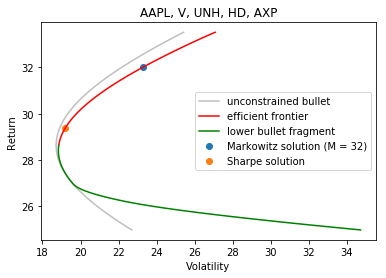

In [15]:
# top 5 assets with largest return
assets = rets_vols(ct, mt).sort_values('Return', ascending=False).index[:5]
M = 32
r = 3
aaa = dj_port(ct, mt, M, r, assets)
summary_dj.loc['Markowitz, 5 highest return stocks', :] = aaa[:4]
summary_dj.loc['Sharpe, 5 highest return stocks', :] = aaa[4:]

<a href="#toc">Back to table of contents</a>

<a name="low_risk"></a>

### Allocation among top 5 stocks with lowest risk

============================= Constrained problem ========================
Markowitz solution for M = 12.000:  risk 152.807, vol 12.362, weights, % 43.9, 2.3, 32.7, 18.5, 2.6, active JNJ,PG,MCD,KO,WMT
Sharpe solution:    return 12.320,  risk 158.950, vol 12.608, weights, % 46.3, 38.8, 14.8, active JNJ,MCD,KO


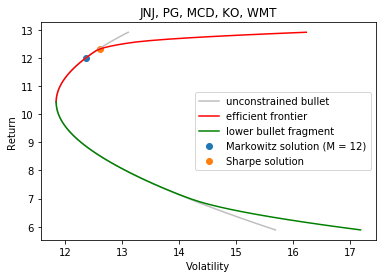

In [16]:
# top 5 assets with lowest risk
assets = rets_vols(ct, mt).sort_values('Vol').index[:5]
M = 12
r = 3
aaa = dj_port(ct, mt, M, r, assets)
summary_dj.loc['Markowitz, 5 lowest risk stocks', :] = aaa[:4]
summary_dj.loc['Sharpe, 5 lowest risk stocks', :] = aaa[4:]

<a href="#toc">Back to table of contents</a>

<a name="dj_all"></a>

### Allocation among total Dow Jones universe

============================= Constrained problem ========================
Markowitz solution for M = 28.000:  risk 334.601, vol 18.292, weights, % 32.5, 27.6, 5.2, 2.0, 1.3, 15.9, 15.6, active AAPL,HD,JNJ,MCD,NKE,UNH,V
Sharpe solution:    return 29.454,  risk 370.628, vol 19.252, weights, % 37.8, 28.7, 16.9, 16.5, active AAPL,HD,UNH,V


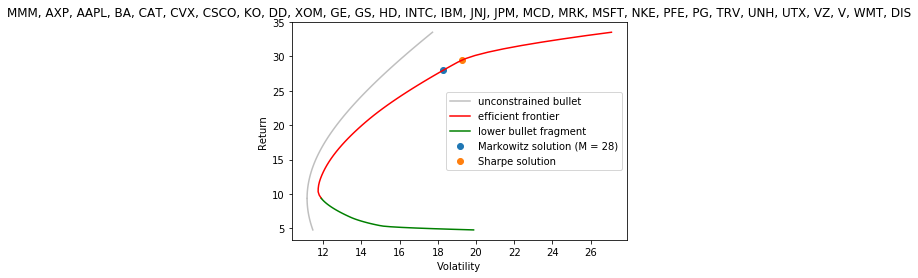

In [17]:
# total DJ universe of 30 stocks
assets = mt.index
M = 28
r = 5
aaa = dj_port(ct, mt, M, r, assets)
summary_dj.loc['Markowitz, all Dow Jones stocks', :] = aaa[:4]
summary_dj.loc['Sharpe, all Dow Jones stocks', :] = aaa[4:]

<a href="#toc">Back to table of contents</a>

<a name="summary_dj"></a>

### Summary of Dow Jones allocation

In [18]:
summary_dj

,Return,Volatility,"Weights, %",Stocks
"Markowitz, 5 highest return stocks",32.000,23.272,"76.6, 8.7, 6.9, 7.9","AAPL,V,UNH,HD"
"Sharpe, 5 highest return stocks",29.372,19.189,"36.5, 16.8, 17.2, 29.4","AAPL,V,UNH,HD"
"Markowitz, 5 lowest risk stocks",12.000,12.362,"43.9, 2.3, 32.7, 18.5, 2.6","JNJ,PG,MCD,KO,WMT"
"Sharpe, 5 lowest risk stocks",12.320,12.608,"46.3, 38.8, 14.8","JNJ,MCD,KO"
"Markowitz, all Dow Jones stocks",28.000,18.292,"32.5, 27.6, 5.2, 2.0, 1.3, 15.9, 15.6","AAPL,HD,JNJ,MCD,NKE,UNH,V"
"Sharpe, all Dow Jones stocks",29.454,19.252,"37.8, 28.7, 16.9, 16.5","AAPL,HD,UNH,V"


We see that typically Sharpe ratio method achieves results similar to those of Markowitz method, used to include less assets in an optmal portfolio, and do not require setting the $M$ parameter. Only if the Sharpe solution looks too risky, or provides too small return, one would move to the Markowitz approach.